# Define External Validation Area
Delineate a smaller, spatially separate hold-out area in a geologically similar province (e.g., a portion of the North Carolina Piedmont) that will be used only for final model validation.

In [1]:
# 1) Imports & engine detection
from pathlib import Path
import warnings
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, box
import matplotlib.pyplot as plt

# Prefer pyogrio; fall back to fiona
def _choose_engine():
    try:
        import pyogrio  # noqa
        return "pyogrio"
    except Exception:
        try:
            import fiona  # noqa
            return "fiona"
        except Exception:
            raise ImportError(
                "Neither 'pyogrio' nor 'fiona' available.\n"
                "Install one:\n  conda install -c conda-forge pyogrio\n"
                "or\n  conda install -c conda-forge fiona"
            )
IO_ENGINE = _choose_engine()
print("Vector I/O engine:", IO_ENGINE)


Vector I/O engine: pyogrio


In [2]:
# 2) Configuration
# Inputs from 1.1 (standardized outputs)
DATA_PROCESSED = Path("../../data/processed")
PROVINCES_GPKG = DATA_PROCESSED / "study_area_provinces.gpkg"
LAYER_PROVINCES = "provinces"

# Outputs for 1.2
OUT_GPKG = DATA_PROCESSED / "external_validation.gpkg"
LAYER_EVA = "external_validation_area"
META_JSON = DATA_PROCESSED / "external_validation_meta.json"

# Coordinate systems
CRS_EQAREA = "EPSG:5070"   # analysis CRS (matches 1.1)
CRS_GEO = "EPSG:4326"      # lat/lon for bbox entry

# --- EDIT ME (choose the *similar* province you want to hold out) ---
VALIDATION_PROVINCE = "PIEDMONT"  # e.g., "PIEDMONT", "COASTAL PLAIN", etc. (UPPERCASE)

# --- EDIT ME (lon/lat bounding box over your target sub-region, e.g., NC Piedmont) ---
# Example covers a swath of central NC; adjust as needed:
BBOX_LONLAT = {
    "minx": -81.8,  # EDIT ME
    "miny":  35.2,  # EDIT ME
    "maxx": -78.5,  # EDIT ME
    "maxy":  36.2,  # EDIT ME
}

# --- EDIT ME (meters): inward buffer to avoid province edges/transition zones ---
INWARD_BUFFER_M = 5000  # 5 km inside the province boundary to reduce edge effects

# Minimum acceptable area for the EVA (m^2) — guardrail so we don't end up too small
MIN_EVA_AREA_M2 = 50_000_000  # 50 km^2


In [3]:
# 3) Load provinces (standardized by 1.1) + make geometry column active/safe
print(f"Reading provinces from: {PROVINCES_GPKG} | layer='{LAYER_PROVINCES}'")
provinces = gpd.read_file(PROVINCES_GPKG, layer=LAYER_PROVINCES, engine=IO_ENGINE)

# Ensure expected CRS for analysis
if provinces.crs is None or provinces.crs.to_string() != CRS_EQAREA:
    provinces = provinces.to_crs(CRS_EQAREA)

# Normalize column names but PRESERVE geometry accessor
orig_geom_name = provinces.geometry.name  # often "geometry"
rename_map = {c: c.upper() for c in provinces.columns if c != orig_geom_name}
provinces = provinces.rename(columns=rename_map)

# Detect geometry-typed columns and (re)activate the right one
geom_cols = [c for c in provinces.columns if getattr(provinces[c], "dtype", None) and provinces[c].dtype.name == "geometry"]
if not geom_cols:
    raise AttributeError("No geometry-typed column found in provinces.")
active_geom = orig_geom_name if orig_geom_name in provinces.columns else geom_cols[0]
if provinces.geometry.name != active_geom:
    provinces = provinces.set_geometry(active_geom)
if provinces.geometry.name != "geometry":
    provinces = provinces.rename_geometry("geometry")

# Schema checks
if "PROVINCE" not in provinces.columns:
    raise ValueError(f"'PROVINCE' column not found. Columns: {list(provinces.columns)}")

print("Detected provinces:", sorted(provinces["PROVINCE"].unique()))
display(provinces.head())


Reading provinces from: ..\..\data\processed\study_area_provinces.gpkg | layer='provinces'
Detected provinces: ['APPALACHIAN PLATEAUS', 'BASIN AND RANGE', 'BLUE RIDGE', 'COASTAL PLAIN', 'PIEDMONT', 'VALLEY AND RIDGE']


,PROVINCE,PROVCODE,SHAPE_LENG,SHAPE_AREA,IS_CONTROL,geometry
0,APPALACHIAN PLATEAUS,8,43.626928,30.887238,False,"MULTIPOLYGON (((1026718.603 1677862.72, 102831..."
1,BASIN AND RANGE,22,71.632279,90.923162,False,"MULTIPOLYGON (((-697374.252 682455.866, -70418..."
2,BLUE RIDGE,5,20.833002,4.692015,False,"MULTIPOLYGON (((1411045.108 1696428.839, 14119..."
3,COASTAL PLAIN,3,306.942823,107.777346,False,"MULTIPOLYGON (((-120374.248 356594.107, -11914..."
4,PIEDMONT,4,34.302366,20.211476,True,"MULTIPOLYGON (((1652043.9 2100890.912, 1658409..."


In [4]:
# 4) Build candidate AOI and clip to chosen province (robust inward buffer)
# Make bbox in EPSG:4326 and project to analysis CRS
bbox4326 = box(BBOX_LONLAT["minx"], BBOX_LONLAT["miny"], BBOX_LONLAT["maxx"], BBOX_LONLAT["maxy"])
bbox_gdf = gpd.GeoDataFrame({"source": ["bbox"]}, geometry=[bbox4326], crs=CRS_GEO)
bbox_proj = bbox_gdf.to_crs(CRS_EQAREA)

# Select the target (similar) province for EVA (e.g., PIEDMONT)
if VALIDATION_PROVINCE not in set(provinces["PROVINCE"].unique()):
    raise ValueError(f"VALIDATION_PROVINCE='{VALIDATION_PROVINCE}' not found in provinces.")
target_prov = provinces.loc[provinces["PROVINCE"].eq(VALIDATION_PROVINCE), ["PROVINCE", "geometry"]].copy()

# Dissolve to one multipart geometry, then unary_union to a single shapely geometry
target_union = target_prov.union_all()

# Inward buffer (robust): shrink if it collapses
buf_dist = float(INWARD_BUFFER_M) if INWARD_BUFFER_M else 0.0
geom_in = target_union
if buf_dist > 0:
    # Try full buffer; if empty, progressively reduce
    for factor in [1.0, 0.75, 0.5, 0.25]:
        geom_try = target_union.buffer(-buf_dist * factor)
        if not geom_try.is_empty:
            geom_in = geom_try
            if factor < 1.0:
                warnings.warn(f"Inward buffer reduced to {int(100*factor)}% to avoid empty geometry.")
            break
    else:
        warnings.warn("Inward buffer produced empty geometry; using unbuffered province geometry.")
        geom_in = target_union

# Convert back to GeoDataFrame
target_trim = gpd.GeoDataFrame({"PROVINCE": [VALIDATION_PROVINCE]}, geometry=[geom_in], crs=CRS_EQAREA)

# Intersect bbox with inward-trimmed province
eva = gpd.overlay(target_trim, bbox_proj, how="intersection")

# Clean & fix
eva = eva[~eva.geometry.is_empty].copy()
if not eva.geometry.is_valid.all():
    from shapely import make_valid
    eva["geometry"] = eva.geometry.apply(make_valid)

eva["EVA_NAME"] = f"{VALIDATION_PROVINCE} EVA"
eva["SOURCE"] = "BBOX ∩ PROVINCE (inward buffered)"


In [5]:
# 5) QA checks
if len(eva) == 0:
    raise AssertionError(
        "External validation area is empty. Adjust BBOX_LONLAT to intersect your chosen province."
    )

# Dissolve in case the intersection created multiple parts
eva = eva.dissolve(by="EVA_NAME", as_index=False, aggfunc="first").reset_index(drop=True)

# Area check
eva["AREA_M2"] = eva.geometry.area
total_area = float(eva["AREA_M2"].sum())
print(f"EVA area (km^2): {total_area/1e6:.2f}")

assert total_area >= MIN_EVA_AREA_M2, (
    f"EVA too small ({total_area/1e6:.2f} km^2). "
    f"Increase bbox or reduce inward buffer."
)

# (Optional) Separation note:
# At Week 1, we don't yet have final training samples; later we will enforce distance > d from any training point.
# For now, we ensured inward buffer from province edges and spatial separation from the *training data* by design:
# The EVA lives in a user-specified subregion and will be excluded from all draws.


EVA area (km^2): 28571.49


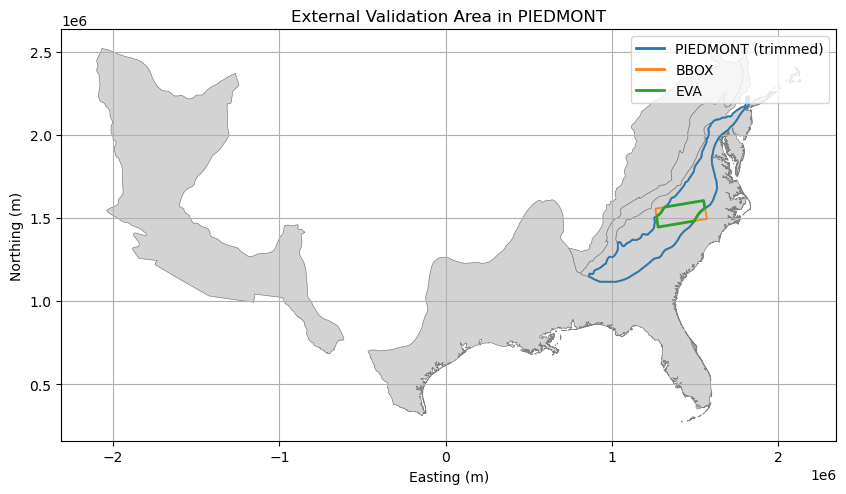

In [6]:
# Visualization (clean legend handling)
fig, ax = plt.subplots(figsize=(10, 10))

# Provinces background (gray, no label so it doesn't clutter legend)
provinces.plot(ax=ax, color="lightgray", edgecolor="gray", linewidth=0.5)

# Plot chosen province outline
target_trim.boundary.plot(ax=ax, color="tab:blue", linewidth=1.2)
blue_patch = plt.Line2D([0], [0], color="tab:blue", lw=2, label=f"{VALIDATION_PROVINCE} (trimmed)")

# Plot bbox outline
bbox_proj.boundary.plot(ax=ax, color="tab:orange", linewidth=1.2)
orange_patch = plt.Line2D([0], [0], color="tab:orange", lw=2, label="BBOX")

# Plot EVA outline
eva.boundary.plot(ax=ax, color="tab:green", linewidth=2)
green_patch = plt.Line2D([0], [0], color="tab:green", lw=2, label="EVA")

# Legend from custom handles
ax.legend(handles=[blue_patch, orange_patch, green_patch], loc="best")

ax.set_title(f"External Validation Area in {VALIDATION_PROVINCE}")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.grid(True)
plt.show()


In [7]:
# 7) Save outputs (clean schema first)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# 7a) ensure clean, minimal columns (avoid case-insensitive duplicates in GPKG/SQLite)
# compute area if not already present
if "AREA_M2" not in eva.columns:
    eva["AREA_M2"] = eva.geometry.area

# keep only the essentials
keep_cols = ["EVA_NAME", "PROVINCE", "AREA_M2", "geometry"]
missing = [c for c in keep_cols if c not in eva.columns]
if missing:
    raise ValueError(f"Missing expected columns before write: {missing}")

eva_out = eva[keep_cols].copy()

# (optional) enforce geometry name and CRS just to be safe
if eva_out.geometry.name != "geometry":
    eva_out = eva_out.rename_geometry("geometry")
if eva_out.crs is None or eva_out.crs.to_string() != CRS_EQAREA:
    eva_out = eva_out.set_crs(CRS_EQAREA)

print(f"Writing EVA to: {OUT_GPKG} (layer='{LAYER_EVA}')")
eva_out.to_file(OUT_GPKG, layer=LAYER_EVA, driver="GPKG", engine=IO_ENGINE)

# Sidecar metadata (provenance + parameters)
meta = {
    "validation_province": VALIDATION_PROVINCE,
    "bbox_lonlat": BBOX_LONLAT,
    "inward_buffer_m": INWARD_BUFFER_M,
    "area_m2": float(eva_out["AREA_M2"].sum()),
    "crs": CRS_EQAREA,
    "created_from": {
        "provinces_gpkg": str(PROVINCES_GPKG),
        "provinces_layer": LAYER_PROVINCES,
    },
}
with open(META_JSON, "w") as f:
    import json
    json.dump(meta, f, indent=2)

print("Done.")


Writing EVA to: ..\..\data\processed\external_validation.gpkg (layer='external_validation_area')
Done.
